# Customer Segmentation based on Credit Card usage behaviour

**1. Balance**
* BALANCE: Balance amount left in their account to make purchases (
* BALANCEFREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

**2. Purchases**
* PURCHASES: Amount of purchases made from account
* ONEOFFPURCHASES: Maximum purchase amount done in one-go
* INSTALLMENTSPURCHASES: Amount of purchase done in installment

**3. Purchases Frequency**
* PURCHASESFREQUENCY: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
* ONEOFFPURCHASESFREQUENCY: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
* PURCHASESINSTALLMENTSFREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
* PURCHASESTRX: Number of purchase transactions made

**4. Cash Advance**
* CASHADVANCE: Cash in advance given by the user
* CASHADVANCEFREQUENCY: How frequently the cash in advance being paid
* CASHADVANCETRX: Number of Transactions made with "Cash in Advanced"

**5. Payments**
* PAYMENTS: Amount of Payment done by user
* MINIMUM_PAYMENTS: Minimum amount of payments made by user
* PRCFULLPAYMENT: Percent of full payment paid by user

**6. Others**
* CUSTID: Identification of Credit Card holder (Categorical)
* CREDITLIMIT: Limit of Credit Card for user
* TENURE: Tenure of credit card service for user

In [1]:
import numpy as np
import itertools
import pandas as pd
import scipy
import seaborn as sns
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score

In [2]:

cc=pd.read_csv('CC GENERAL.csv',sep=",",decimal='.')
cc=cc.drop('CUST_ID',axis=1)

In [18]:
cc.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [19]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [20]:
cc.isna().any()

BALANCE                             False
BALANCE_FREQUENCY                   False
PURCHASES                           False
ONEOFF_PURCHASES                    False
INSTALLMENTS_PURCHASES              False
CASH_ADVANCE                        False
PURCHASES_FREQUENCY                 False
ONEOFF_PURCHASES_FREQUENCY          False
PURCHASES_INSTALLMENTS_FREQUENCY    False
CASH_ADVANCE_FREQUENCY              False
CASH_ADVANCE_TRX                    False
PURCHASES_TRX                       False
CREDIT_LIMIT                         True
PAYMENTS                            False
MINIMUM_PAYMENTS                     True
PRC_FULL_PAYMENT                    False
TENURE                              False
dtype: bool

Text(0.5, 1.0, 'Kernel Density Estimation Plot')

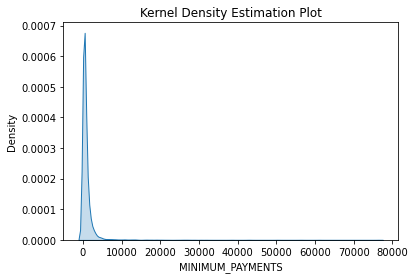

In [21]:
sns.kdeplot(cc['MINIMUM_PAYMENTS'], shade=True) 
plt.title('Kernel Density Estimation Plot')

##### positive skewness occurs because the dataset contains values much greater than the mean but far fewer values less than the mean-existence of outliers

In [22]:
#CREDIT_LIMIT and MINIMUM_PAYMENTS contain nan values, so we replace these values by the mean of coresponding column

In [3]:
cc_mean=cc
cc_mean.loc[(cc_mean['MINIMUM_PAYMENTS'].isnull() == True), 'MINIMUM_PAYMENTS'] = cc_mean['MINIMUM_PAYMENTS'].mean()
cc_mean.loc[(cc_mean['CREDIT_LIMIT'].isnull() == True), 'CREDIT_LIMIT'] = cc_mean['CREDIT_LIMIT'].mean()


# Exploratory Data Analysis

##### Descriptive Statistics of Data

In [24]:
cc_mean.describe() #data have many outliers

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.612411,2895.063757,2330.588021,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,170.857654,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,335.628312,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,864.206542,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [4]:
columns=cc_mean.columns

In [ ]:
#Too many outliers

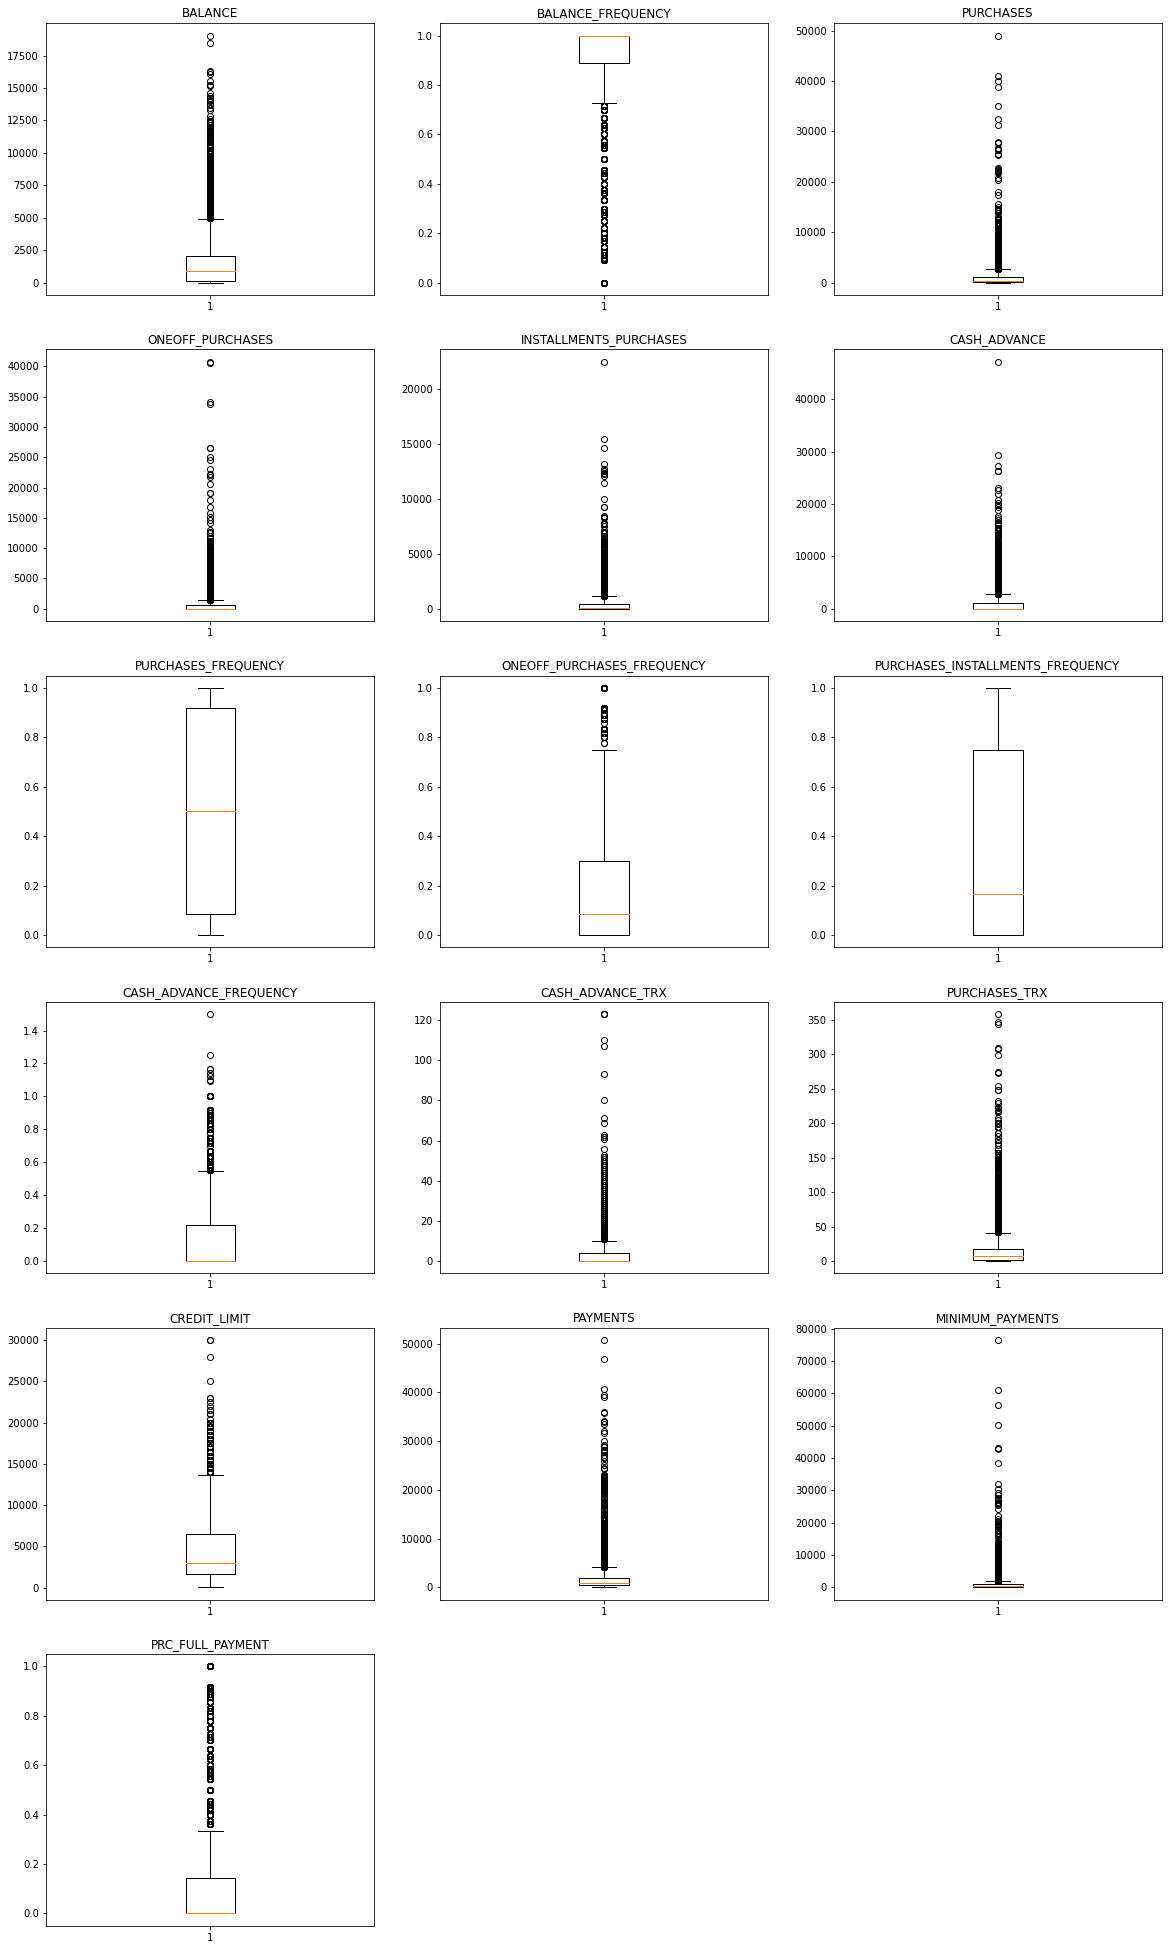

In [5]:
plt.figure(figsize=(20,35))

for i in range(0,16):
    plt.subplot(6, 3, i+1)
    plt.boxplot(cc_mean[columns[i]])
    plt.title(columns[i])

**Feature Distribution**

KDE (Kernel Density Estimation) plot for each feature

Text(0.5, 0.98, 'Kernel Density Estimation Plot')

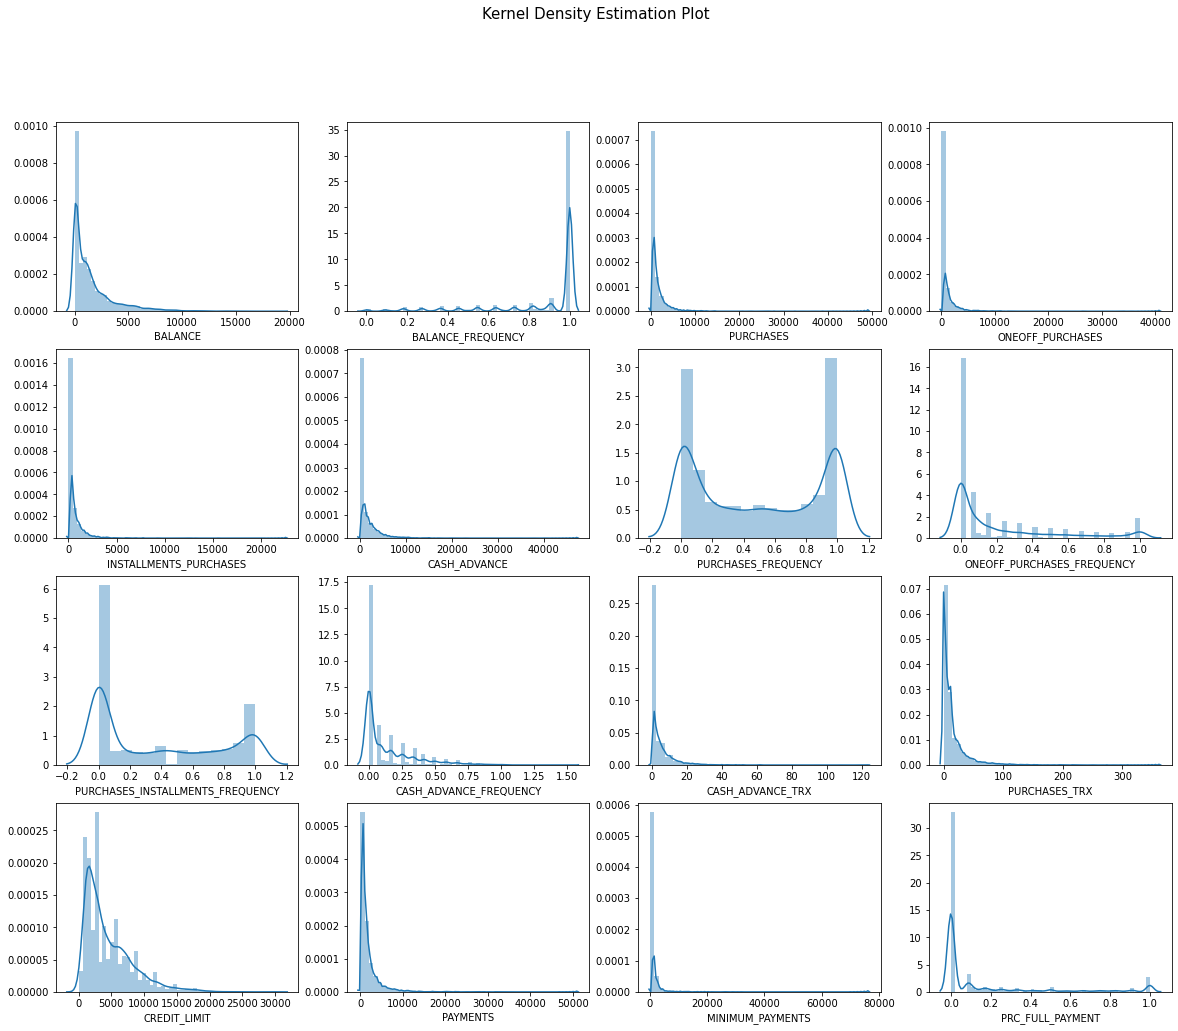

In [6]:

r,c=0,0
fig, axes=plt.subplots(4,4, figsize=(20,16))
#plt.tight_layout()
for i in columns:
    sns.distplot(cc_mean[i], ax=axes[r,c])
    c += 1
    if c == 4: 
        r += 1
        c=0
    if r == 4: break
plt.suptitle('Kernel Density Estimation Plot', fontsize=15)

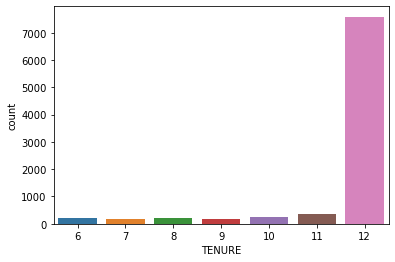

In [7]:
sns.countplot(cc_mean.TENURE)

**Correlation Matrix**

Note:
To avoid the top and bottom boxes are cut off, we need to downgrade matplotlib (conda install -c conda-forge matplotlib=3.1.2)

Text(0.5, 1.0, 'Correlation Matrix')

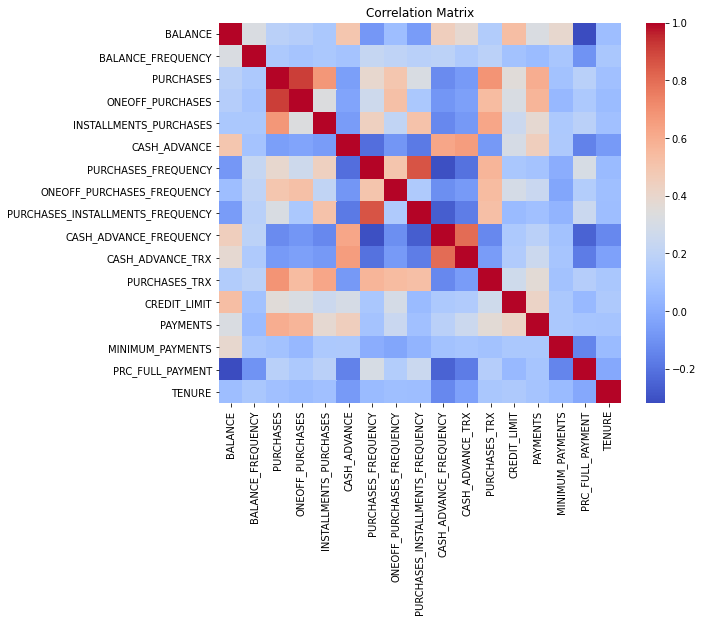

In [28]:
plt.figure(figsize=(9,7))
sns.heatmap(cc_mean.corr(),cmap='coolwarm')

plt.title('Correlation Matrix')

In [29]:
corr_coef=cc_mean.corr()

In [30]:
# Find out feature pairs whose coefficient >= 0.7
corr_cols=corr_coef.columns.to_list() 
negat_corr=[]
for i in range(len(corr_cols)):
    col=corr_cols[i]
    negat_corr.append(abs(corr_coef[col])[abs(corr_coef[col]) <= -0.7])
negat_corr_df=pd.DataFrame(negat_corr)
#negat_corr_df

In [31]:
# Find out feature pairs whose coefficient >= 0.7
corr_cols=corr_coef.columns.to_list() 
signif_corr=[]
for i in range(len(corr_cols)):
    col=corr_cols[i]
    signif_corr.append(abs(corr_coef[col])[abs(corr_coef[col]) >= 0.7])
signif_corr_df=pd.DataFrame(signif_corr)
#signif_corr_df

High Correlation Coefficient Pairs Analysis:

* PURCHASES & ONEOFFPURCHASES: 0.92

When people use one-off purchases, purchase amount is higher than using installment purchases.

* PURCHASESFREQUENCY & PURCHASESINSTALLMENTSFREQUENCY: 0.86

More people use installment purchases.

* CASHADVANCEFREQUENCY & CASHADVANCETRX: 0.80


We will create a better representation of customers by performing a scaling on the data and detecting outliers.
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points.An outlier step is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.We remove data points from the dataset by adding indices to the outliers list.

## Eliminating Outliers

In [32]:
outliers = []

# For each feature find the data points with extreme high or low values
for feature in cc_mean.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(cc_mean[feature], 25.)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(cc_mean[feature], 75.)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3-Q1)*1.5
    print ("Outlier step:", step)
    
    # Display the outliers
    print ("Data points considered outliers for the feature '{}':".format(feature))
    feature_outliers =cc_mean[~((cc_mean[feature] >= Q1 - step) & (cc_mean[feature] <= Q3 + step))]
    display(feature_outliers)
    
    outliers += feature_outliers.index.tolist()
    
# Remove the outliers, if any were specified
good_data=cc_mean.drop(cc_mean.index[outliers]).reset_index(drop = True)
print("Number of outliers (inc duplicates): ", len(outliers))
print("New dataset with removed outliers has {} samples with {} features each.".format(*good_data.shape))

Outlier step: 2888.7871800000003
Data points considered outliers for the feature 'BALANCE':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
15,6886.213231,1.000000,1611.70,0.00,1611.70,2301.491267,0.500000,0.000000,0.500000,0.166667,4,11,8000.0,1993.439277,2109.906490,0.0,12
21,6369.531318,1.000000,6359.95,5910.04,449.91,229.028245,1.000000,0.916667,1.000000,0.333333,6,92,11250.0,2077.959051,1659.775075,0.0,12
24,5368.571219,1.000000,0.00,0.00,0.00,798.949863,0.000000,0.000000,0.000000,0.363636,4,0,6000.0,1422.726707,1657.002877,0.0,11
28,7152.864372,1.000000,387.05,204.55,182.50,2236.145259,0.666667,0.166667,0.416667,0.833333,16,8,10500.0,1601.448347,1648.851345,0.0,12
30,12136.219960,1.000000,3038.01,1013.20,2024.81,3183.583301,1.000000,0.166667,1.000000,0.500000,10,64,13000.0,4230.323491,3292.015030,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,6008.914524,0.777778,0.00,0.00,0.00,8304.470149,0.000000,0.000000,0.000000,0.333333,9,0,9000.0,1279.301117,1404.889491,0.0,9
8411,5934.610587,1.000000,0.00,0.00,0.00,302.678437,0.000000,0.000000,0.000000,0.250000,5,0,6000.0,1065.956065,2394.242819,0.0,12
8438,5484.339435,1.000000,0.00,0.00,0.00,5990.590134,0.000000,0.000000,0.000000,0.250000,14,0,6000.0,1229.434538,2453.164396,0.0,12
8705,7302.672686,1.000000,0.00,0.00,0.00,10762.707760,0.000000,0.000000,0.000000,0.750000,19,0,9000.0,3824.308564,2214.506825,0.0,12


Outlier step: 0.1666665000000001
Data points considered outliers for the feature 'BALANCE_FREQUENCY':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
9,152.225975,0.545455,1281.60,1281.60,0.0,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12
17,41.089489,0.454545,519.00,0.00,519.0,0.000000,0.416667,0.000000,0.333333,0.000000,0,8,2500.0,254.590662,73.203221,0.250000,12
22,132.342240,0.636364,815.90,0.00,815.9,0.000000,1.000000,0.000000,1.000000,0.000000,0,17,1800.0,2359.629958,86.329554,0.000000,12
39,1411.602230,0.454545,963.24,963.24,0.0,6173.682877,0.083333,0.083333,0.000000,0.333333,6,6,7500.0,20071.075440,719.948985,0.333333,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8929,371.527312,0.333333,0.00,0.00,0.0,1465.407927,0.000000,0.000000,0.000000,0.166667,5,0,1500.0,0.000000,864.206542,0.000000,6
8937,163.001629,0.666667,0.00,0.00,0.0,274.440466,0.000000,0.000000,0.000000,0.166667,3,0,1000.0,117.738787,60.792450,0.000000,6
8938,78.818407,0.500000,0.00,0.00,0.0,1113.186078,0.000000,0.000000,0.000000,0.166667,7,0,1200.0,1397.770131,21.821194,0.333333,6
8943,5.871712,0.500000,20.90,20.90,0.0,0.000000,0.166667,0.166667,0.000000,0.000000,0,1,500.0,58.644883,43.473717,0.000000,6


Outlier step: 1605.7425000000003
Data points considered outliers for the feature 'PURCHASES':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
6,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
12,1516.928620,1.000000,3217.99,2500.23,717.76,0.000000,1.000000,0.250000,0.916667,0.000000,0,26,3000.0,608.263689,490.207013,0.250000,12
21,6369.531318,1.000000,6359.95,5910.04,449.91,229.028245,1.000000,0.916667,1.000000,0.333333,6,92,11250.0,2077.959051,1659.775075,0.000000,12
23,3800.151377,0.818182,4248.35,3454.56,793.79,7974.415626,1.000000,0.083333,0.916667,0.333333,13,13,9000.0,9479.043842,1425.426525,0.000000,12
30,12136.219960,1.000000,3038.01,1013.20,2024.81,3183.583301,1.000000,0.166667,1.000000,0.500000,10,64,13000.0,4230.323491,3292.015030,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8689,368.318662,0.909091,8053.95,8053.95,0.00,0.000000,0.833333,0.833333,0.000000,0.000000,0,46,2000.0,7966.582037,219.761189,0.777778,12
8737,2533.618119,0.909091,5633.83,2985.92,2647.91,2451.807788,0.916667,0.500000,0.750000,0.333333,16,82,9000.0,8176.953944,602.963244,0.000000,12
8748,1042.816735,0.625000,3950.00,3950.00,0.00,0.000000,0.250000,0.250000,0.000000,0.000000,0,3,3150.0,6274.982741,303.462882,0.000000,8
8758,1812.542545,0.857143,2918.08,2918.08,0.00,0.000000,0.571429,0.571429,0.000000,0.000000,0,5,3000.0,247.249275,297.395431,0.000000,7


Outlier step: 866.1075000000001
Data points considered outliers for the feature 'ONEOFF_PURCHASES':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
6,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
11,630.794744,0.818182,1492.18,1492.18,0.00,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,2000.0,705.618627,155.549069,0.000000,12
12,1516.928620,1.000000,3217.99,2500.23,717.76,0.000000,1.000000,0.250000,0.916667,0.000000,0,26,3000.0,608.263689,490.207013,0.250000,12
21,6369.531318,1.000000,6359.95,5910.04,449.91,229.028245,1.000000,0.916667,1.000000,0.333333,6,92,11250.0,2077.959051,1659.775075,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8748,1042.816735,0.625000,3950.00,3950.00,0.00,0.000000,0.250000,0.250000,0.000000,0.000000,0,3,3150.0,6274.982741,303.462882,0.000000,8
8758,1812.542545,0.857143,2918.08,2918.08,0.00,0.000000,0.571429,0.571429,0.000000,0.000000,0,5,3000.0,247.249275,297.395431,0.000000,7
8801,275.020950,1.000000,1943.00,1943.00,0.00,0.000000,0.600000,0.600000,0.000000,0.000000,0,9,500.0,1438.120632,142.241273,0.555556,10
8843,751.590839,0.444444,2000.00,2000.00,0.00,0.000000,0.111111,0.111111,0.000000,0.000000,0,1,2000.0,265.918137,353.102768,0.000000,9


Outlier step: 702.95625
Data points considered outliers for the feature 'INSTALLMENTS_PURCHASES':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
13,921.693369,1.000000,2137.93,419.96,1717.97,0.000000,0.750000,0.166667,0.750000,0.000000,0,26,7500.0,1655.891435,251.137986,0.083333,12
15,6886.213231,1.000000,1611.70,0.00,1611.70,2301.491267,0.500000,0.000000,0.500000,0.166667,4,11,8000.0,1993.439277,2109.906490,0.000000,12
30,12136.219960,1.000000,3038.01,1013.20,2024.81,3183.583301,1.000000,0.166667,1.000000,0.500000,10,64,13000.0,4230.323491,3292.015030,0.000000,12
64,1923.886805,1.000000,1887.64,0.00,1887.64,1605.949371,1.000000,0.000000,1.000000,0.083333,4,61,1850.0,3688.045998,3266.996777,0.083333,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8737,2533.618119,0.909091,5633.83,2985.92,2647.91,2451.807788,0.916667,0.500000,0.750000,0.333333,16,82,9000.0,8176.953944,602.963244,0.000000,12
8764,708.315197,1.000000,2252.32,452.32,1800.00,0.000000,0.818182,0.181818,0.727273,0.000000,0,12,2500.0,2155.891761,208.895886,0.100000,11
8837,272.624436,0.888889,1843.00,470.00,1373.00,0.000000,0.666667,0.111111,0.444444,0.000000,0,6,1000.0,1477.357626,140.980969,0.400000,9
8839,3271.424058,0.888889,1173.28,0.00,1173.28,4122.912645,0.888889,0.000000,0.777778,0.333333,4,16,5000.0,817.177789,999.725550,0.000000,9


Outlier step: 1670.7317088749996
Data points considered outliers for the feature 'CASH_ADVANCE':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
23,3800.151377,0.818182,4248.35,3454.56,793.79,7974.415626,1.000000,0.083333,0.916667,0.333333,13,13,9000.0,9479.043842,1425.426525,0.000000,12
30,12136.219960,1.000000,3038.01,1013.20,2024.81,3183.583301,1.000000,0.166667,1.000000,0.500000,10,64,13000.0,4230.323491,3292.015030,0.000000,12
36,7427.076941,1.000000,0.00,0.00,0.00,8873.375046,0.000000,0.000000,0.000000,0.727273,11,0,9000.0,1636.361601,1986.843608,0.000000,11
38,6269.418144,1.000000,204.00,204.00,0.00,2925.699862,0.083333,0.083333,0.000000,0.333333,12,2,9000.0,1237.111661,2049.408839,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8839,3271.424058,0.888889,1173.28,0.00,1173.28,4122.912645,0.888889,0.000000,0.777778,0.333333,4,16,5000.0,817.177789,999.725550,0.000000,9
8840,2588.410789,0.888889,787.40,0.00,787.40,3762.650329,0.777778,0.000000,0.666667,0.555556,10,17,3000.0,1739.406636,1769.001229,0.000000,9
8857,2330.222764,1.000000,1320.00,0.00,1320.00,14926.790590,0.428571,0.000000,0.285714,0.571429,10,3,10000.0,8157.666434,283.362434,0.200000,7
8863,1382.936306,0.875000,336.00,0.00,336.00,4158.990631,0.875000,0.000000,0.750000,0.125000,5,7,4000.0,754.256439,681.059427,0.600000,8


Outlier step: 1.2500010000000001
Data points considered outliers for the feature 'PURCHASES_FREQUENCY':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE


Outlier step: 0.44999999999999996
Data points considered outliers for the feature 'ONEOFF_PURCHASES_FREQUENCY':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
6,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
21,6369.531318,1.000000,6359.95,5910.04,449.91,229.028245,1.000000,0.916667,1.000000,0.333333,6,92,11250.0,2077.959051,1659.775075,0.000000,12
33,125.660453,1.000000,636.79,636.79,0.00,0.000000,0.916667,0.916667,0.000000,0.000000,0,11,1200.0,423.449696,196.301885,0.300000,12
57,2386.330629,1.000000,5217.62,4789.09,428.53,0.000000,0.916667,0.916667,0.500000,0.000000,0,42,7500.0,5678.729613,1311.514878,0.083333,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8707,78.448912,1.000000,1875.18,977.85,897.33,0.000000,1.000000,0.833333,0.916667,0.000000,0,78,1200.0,1656.503571,172.161277,1.000000,12
8792,1176.365274,0.833333,635.02,348.46,286.56,1937.399142,0.833333,0.833333,0.500000,0.666667,12,18,2400.0,549.873076,752.210311,0.000000,6
8825,72.881984,1.000000,654.84,460.89,193.95,0.000000,1.000000,0.888889,0.888889,0.000000,0,17,1500.0,580.489782,130.035215,0.714286,9
8835,1868.576501,1.000000,1337.34,1294.84,42.50,3132.667468,0.833333,0.833333,0.166667,1.000000,10,23,3000.0,3236.129237,384.230828,0.000000,6


Outlier step: 1.125
Data points considered outliers for the feature 'PURCHASES_INSTALLMENTS_FREQUENCY':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE


Outlier step: 0.333333
Data points considered outliers for the feature 'CASH_ADVANCE_FREQUENCY':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
28,7152.864372,1.000000,387.05,204.55,182.50,2236.145259,0.666667,0.166667,0.416667,0.833333,16,8,10500.0,1601.448347,1648.851345,0.000000,12
36,7427.076941,1.000000,0.00,0.00,0.00,8873.375046,0.000000,0.000000,0.000000,0.727273,11,0,9000.0,1636.361601,1986.843608,0.000000,11
50,4931.331857,1.000000,901.42,646.07,255.35,8530.648614,0.625000,0.375000,0.250000,0.875000,37,9,12000.0,8113.297346,1012.415961,0.000000,8
71,2990.422186,0.909091,4523.27,1664.09,2859.18,27296.485760,0.666667,0.500000,0.583333,0.833333,27,33,7000.0,28232.694460,1107.030803,0.454545,12
86,7069.950386,1.000000,1603.78,1445.14,158.64,5626.004046,1.000000,0.833333,1.000000,0.750000,23,23,11000.0,4589.873897,1876.262988,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8858,812.934042,1.000000,50.00,50.00,0.00,2185.500596,0.142857,0.142857,0.000000,1.000000,16,1,3000.0,726.683966,127.843735,0.000000,7
8869,2171.222526,1.000000,791.18,791.18,0.00,2056.602480,0.428571,0.428571,0.000000,0.571429,6,8,3000.0,300.088696,453.100425,0.000000,7
8912,376.547421,0.857143,520.00,280.00,240.00,1178.402416,0.857143,0.142857,0.714286,0.714286,9,7,1000.0,929.415656,103.927887,0.200000,7
8915,381.341657,1.000000,78.00,0.00,78.00,934.808869,1.000000,0.000000,0.833333,0.666667,16,6,1000.0,143.118373,85.152441,0.000000,6


Outlier step: 6.0
Data points considered outliers for the feature 'CASH_ADVANCE_TRX':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
23,3800.151377,0.818182,4248.35,3454.56,793.79,7974.415626,1.000000,0.083333,0.916667,0.333333,13,13,9000.0,9479.043842,1425.426525,0.000000,12
28,7152.864372,1.000000,387.05,204.55,182.50,2236.145259,0.666667,0.166667,0.416667,0.833333,16,8,10500.0,1601.448347,1648.851345,0.000000,12
36,7427.076941,1.000000,0.00,0.00,0.00,8873.375046,0.000000,0.000000,0.000000,0.727273,11,0,9000.0,1636.361601,1986.843608,0.000000,11
38,6269.418144,1.000000,204.00,204.00,0.00,2925.699862,0.083333,0.083333,0.000000,0.333333,12,2,9000.0,1237.111661,2049.408839,0.000000,12
41,784.889762,0.909091,1526.59,786.30,740.29,2188.419607,0.583333,0.416667,0.333333,0.250000,11,27,3000.0,1262.309666,363.142736,0.111111,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8858,812.934042,1.000000,50.00,50.00,0.00,2185.500596,0.142857,0.142857,0.000000,1.000000,16,1,3000.0,726.683966,127.843735,0.000000,7
8868,380.839064,0.857143,0.00,0.00,0.00,703.941544,0.000000,0.000000,0.000000,0.428571,13,0,500.0,321.382010,123.667130,0.000000,7
8872,600.052391,1.000000,274.00,0.00,274.00,821.878829,1.000000,0.000000,0.875000,0.500000,13,8,1000.0,151.304337,245.340184,0.000000,8
8915,381.341657,1.000000,78.00,0.00,78.00,934.808869,1.000000,0.000000,0.833333,0.666667,16,6,1000.0,143.118373,85.152441,0.000000,6


Outlier step: 24.0
Data points considered outliers for the feature 'PURCHASES_TRX':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
6,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
21,6369.531318,1.000000,6359.95,5910.04,449.91,229.028245,1.000000,0.916667,1.000000,0.333333,6,92,11250.0,2077.959051,1659.775075,0.000000,12
30,12136.219960,1.000000,3038.01,1013.20,2024.81,3183.583301,1.000000,0.166667,1.000000,0.500000,10,64,13000.0,4230.323491,3292.015030,0.000000,12
31,1162.273324,1.000000,1347.71,400.00,947.71,175.815755,1.000000,0.083333,1.000000,0.166667,2,45,6000.0,645.998299,256.848991,0.000000,12
48,229.867179,1.000000,2390.60,1402.93,987.67,0.000000,1.000000,0.666667,1.000000,0.000000,0,87,3300.0,2543.953559,175.657825,0.916667,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8689,368.318662,0.909091,8053.95,8053.95,0.00,0.000000,0.833333,0.833333,0.000000,0.000000,0,46,2000.0,7966.582037,219.761189,0.777778,12
8707,78.448912,1.000000,1875.18,977.85,897.33,0.000000,1.000000,0.833333,0.916667,0.000000,0,78,1200.0,1656.503571,172.161277,1.000000,12
8737,2533.618119,0.909091,5633.83,2985.92,2647.91,2451.807788,0.916667,0.500000,0.750000,0.333333,16,82,9000.0,8176.953944,602.963244,0.000000,12
8847,224.692470,0.888889,1112.07,0.00,1112.07,0.000000,0.888889,0.000000,0.777778,0.000000,0,44,1500.0,900.366427,151.429715,0.000000,9


Outlier step: 7350.0
Data points considered outliers for the feature 'CREDIT_LIMIT':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
85,134.917202,1.000000,1247.80,1247.80,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,22,16500.0,1275.229436,171.357189,1.00,12
120,8504.876253,1.000000,6724.26,4100.08,2624.18,1686.599777,1.000000,0.916667,1.000000,0.500000,10,85,17000.0,1888.756861,2167.446204,0.00,12
124,14224.115410,1.000000,0.00,0.00,0.00,4614.427403,0.000000,0.000000,0.000000,0.333333,9,0,19000.0,3066.614272,3406.258999,0.00,12
128,11167.234030,1.000000,150.64,150.64,0.00,8362.154254,0.083333,0.083333,0.000000,0.500000,14,1,17000.0,2606.059389,2894.077159,0.00,12
136,2494.868559,1.000000,5491.79,1390.50,4101.29,0.000000,1.000000,0.500000,1.000000,0.000000,0,52,17000.0,1015.311953,615.924020,0.00,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6629,16259.448570,1.000000,5024.68,3582.45,1442.23,328.698275,1.000000,0.833333,1.000000,0.083333,2,143,18000.0,4987.235359,5137.504664,0.00,12
7046,2980.054695,0.818182,26784.62,26514.32,270.30,0.000000,0.583333,0.500000,0.083333,0.000000,0,33,30000.0,30029.014960,11853.796130,0.75,12
7764,10856.483010,1.000000,45.65,45.65,0.00,5096.886673,0.083333,0.083333,0.000000,0.250000,5,1,14500.0,2670.733732,2917.469357,0.00,12
7962,13318.659120,1.000000,3504.74,3266.29,238.45,1306.849608,0.636364,0.545455,0.272727,0.181818,3,16,17500.0,2594.820938,4762.246065,0.00,11


Outlier step: 2276.7872261249995
Data points considered outliers for the feature 'PAYMENTS':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
6,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
23,3800.151377,0.818182,4248.35,3454.56,793.79,7974.415626,1.000000,0.083333,0.916667,0.333333,13,13,9000.0,9479.043842,1425.426525,0.000000,12
30,12136.219960,1.000000,3038.01,1013.20,2024.81,3183.583301,1.000000,0.166667,1.000000,0.500000,10,64,13000.0,4230.323491,3292.015030,0.000000,12
34,3517.101616,0.727273,547.28,0.00,547.28,0.000000,1.000000,0.000000,1.000000,0.000000,0,14,11000.0,8735.607835,17862.558310,0.000000,12
39,1411.602230,0.454545,963.24,963.24,0.00,6173.682877,0.083333,0.083333,0.000000,0.333333,6,6,7500.0,20071.075440,719.948985,0.333333,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8689,368.318662,0.909091,8053.95,8053.95,0.00,0.000000,0.833333,0.833333,0.000000,0.000000,0,46,2000.0,7966.582037,219.761189,0.777778,12
8737,2533.618119,0.909091,5633.83,2985.92,2647.91,2451.807788,0.916667,0.500000,0.750000,0.333333,16,82,9000.0,8176.953944,602.963244,0.000000,12
8748,1042.816735,0.625000,3950.00,3950.00,0.00,0.000000,0.250000,0.250000,0.000000,0.000000,0,3,3150.0,6274.982741,303.462882,0.000000,8
8857,2330.222764,1.000000,1320.00,0.00,1320.00,14926.790590,0.428571,0.000000,0.285714,0.571429,10,3,10000.0,8157.666434,283.362434,0.200000,7


Outlier step: 1040.0233320826221
Data points considered outliers for the feature 'MINIMUM_PAYMENTS':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5,1809.828751,1.0,1333.28,0.0,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
10,1293.124939,1.0,920.12,0.0,920.12,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,1200.0,1083.301007,2172.697765,0.000000,12
15,6886.213231,1.0,1611.70,0.0,1611.70,2301.491267,0.500000,0.000000,0.500000,0.166667,4,11,8000.0,1993.439277,2109.906490,0.000000,12
19,3577.970933,1.0,398.64,0.0,398.64,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,4000.0,1053.980464,12465.549380,0.000000,12
20,2016.684686,1.0,176.68,0.0,176.68,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,2000.0,223.068600,13557.297260,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8705,7302.672686,1.0,0.00,0.0,0.00,10762.707760,0.000000,0.000000,0.000000,0.750000,19,0,9000.0,3824.308564,2214.506825,0.000000,12
8724,3002.791004,1.0,2463.00,2463.0,0.00,797.158950,0.166667,0.166667,0.000000,0.166667,3,3,3000.0,431.716492,16638.733850,0.000000,12
8754,455.471255,1.0,389.70,44.7,345.00,276.902382,1.000000,0.083333,0.916667,0.083333,4,14,1000.0,48.594194,3644.171310,0.090909,12
8873,1023.883008,1.0,585.84,0.0,585.84,956.849209,1.000000,0.000000,0.875000,0.125000,2,22,1000.0,212.105443,2789.590897,0.000000,8


Outlier step: 0.21428549999999996
Data points considered outliers for the feature 'PRC_FULL_PAYMENT':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
6,627.260806,1.000000,7091.01,6402.63,688.38,0.00000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
48,229.867179,1.000000,2390.60,1402.93,987.67,0.00000,1.000000,0.666667,1.000000,0.000000,0,87,3300.0,2543.953559,175.657825,0.916667,12
71,2990.422186,0.909091,4523.27,1664.09,2859.18,27296.48576,0.666667,0.500000,0.583333,0.833333,27,33,7000.0,28232.694460,1107.030803,0.454545,12
82,3.786310,0.636364,133.05,28.20,104.85,0.00000,0.416667,0.166667,0.250000,0.000000,0,5,12000.0,210.053432,99.533735,0.444444,12
83,42.464430,0.545455,396.00,0.00,396.00,0.00000,0.500000,0.000000,0.416667,0.000000,0,12,1200.0,725.606194,140.809454,1.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8932,39.552396,1.000000,180.00,0.00,180.00,0.00000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,138.203240,86.564172,1.000000,6
8934,20.260716,0.833333,110.50,0.00,110.50,0.00000,0.666667,0.000000,0.500000,0.000000,0,4,1500.0,161.476789,65.936751,0.500000,6
8936,108.977282,1.000000,712.50,0.00,712.50,0.00000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,605.716356,86.868595,0.750000,6
8940,130.838554,1.000000,591.24,0.00,591.24,0.00000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,475.523262,82.771320,1.000000,6


Outlier step: 0.0
Data points considered outliers for the feature 'TENURE':


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
16,2072.074354,0.875000,0.00,0.00,0.00,2784.274703,0.000000,0.000000,0.000000,0.250000,3,0,3000.0,391.974562,376.579631,0.00,8
24,5368.571219,1.000000,0.00,0.00,0.00,798.949863,0.000000,0.000000,0.000000,0.363636,4,0,6000.0,1422.726707,1657.002877,0.00,11
36,7427.076941,1.000000,0.00,0.00,0.00,8873.375046,0.000000,0.000000,0.000000,0.727273,11,0,9000.0,1636.361601,1986.843608,0.00,11
46,474.447149,0.500000,109.74,0.00,109.74,1013.659552,0.375000,0.000000,0.250000,0.125000,1,3,1700.0,176.013005,147.199792,0.00,8
50,4931.331857,1.000000,901.42,646.07,255.35,8530.648614,0.625000,0.375000,0.250000,0.875000,37,9,12000.0,8113.297346,1012.415961,0.00,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.50,6
8946,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,864.206542,0.00,6
8947,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.25,6
8948,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.25,6


Number of outliers (inc duplicates):  13453
New dataset with removed outliers has 3008 samples with 17 features each.


In [33]:
from sklearn.preprocessing import StandardScaler,normalize
# Standardize data
scaler = StandardScaler()
scaled = scaler.fit_transform(good_data) 
  
# Normalizing the Data 
normalized_df = normalize(scaled) 

# Converting the numpy array into a pandas DataFrame 
good_data = pd.DataFrame(data=normalized_df,columns=good_data.columns) 


We will use principal component analysis (PCA) to draw conclusions about the underlying structure of the customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we find which compound combinations of features best describe customers.

The data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the explained variance ratio of each dimension — how much variance within the data is explained by that dimension alone. A component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

# PCA 

In [34]:
#good_data=good_data-good_data.mean() #I think we need to make dataset center-reduced and it displays better visuals and meaningful results 

In [35]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.metrics import silhouette_score


def pca_results(good_data, pca):
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
    components.index = dimensions

# PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

# Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

# Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


# Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
            ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

# Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

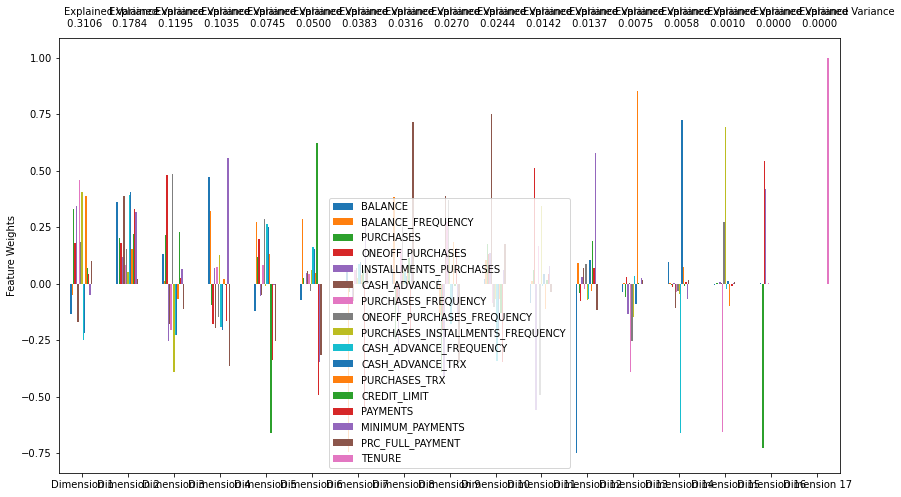

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=17).fit(good_data)

# Generate PCA results plot
pca_results = pca_results(good_data, pca)

First 2 Principal components:

1st PC: 31.06%
2nd PC: 17.84%

Total: 48.90%


When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the cumulative explained variance ratio is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

Text(0.5, 0.98, 'explained variance by dim')

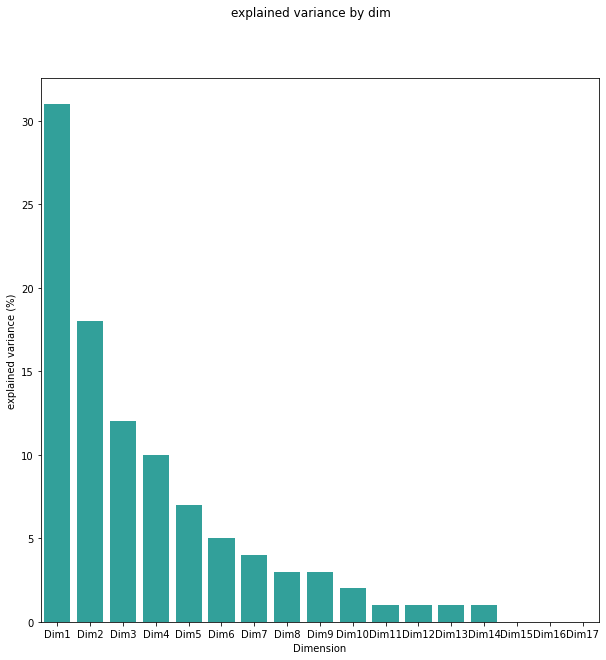

In [37]:
from sklearn import datasets
pca = PCA(n_components=17).fit(good_data)
pca.fit(good_data) 
# it is necessary to have normalized data before performing PCA. 
#The PCA calculates a new projection of data set. And the new axis are based on the standard deviation of variables.
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(17)], 
        "explained_variance" : pca.explained_variance_,
        "% explained_variance" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. explained" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    },
    columns = ["Dimension", "explained_variance", "% explained_variance", "% cum. var. explained"]
)
plt.figure(figsize=(10,10))

g_eig = sns.barplot(x = "Dimension", 
                y = "% explained_variance",
                palette = ["lightseagreen"],
                data = eig)
g_eig.set(ylabel = "explained variance (%)")
g_eig.figure.suptitle("explained variance by dim")



In [38]:
'''plt.figure(figsize=(8,5))
plt.plot(range(1,18),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.title("explained variable by components")
plt.xlabel("number of components")
plt.ylabel("cumulative variance") '''

'plt.figure(figsize=(8,5))\nplt.plot(range(1,18),pca.explained_variance_ratio_.cumsum(),marker=\'o\',linestyle=\'--\')\nplt.title("explained variable by components")\nplt.xlabel("number of components")\nplt.ylabel("cumulative variance") '

In [39]:
## Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(good_data)
reduced_data = pca.transform(good_data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
display(pd.DataFrame(np.round(reduced_data, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-0.1026,-0.5927
1,-0.4052,-0.7171
2,0.7283,-0.0716
3,0.3949,-0.0606
4,-0.6282,0.0888
...,...,...
3003,0.1704,-0.0183
3004,0.7813,-0.3000
3005,0.6034,-0.1680
3006,0.2822,-0.3596


In [40]:
def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute

    return: a matplotlib AxesSubplot object (for any additional customization)
    
    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    '''

    fig, ax = plt.subplots(figsize = (20,20))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 8, 4.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

<AxesSubplot:title={'center':'PC plane with original feature projections.'}, xlabel='Dimension 1', ylabel='Dimension 2'>

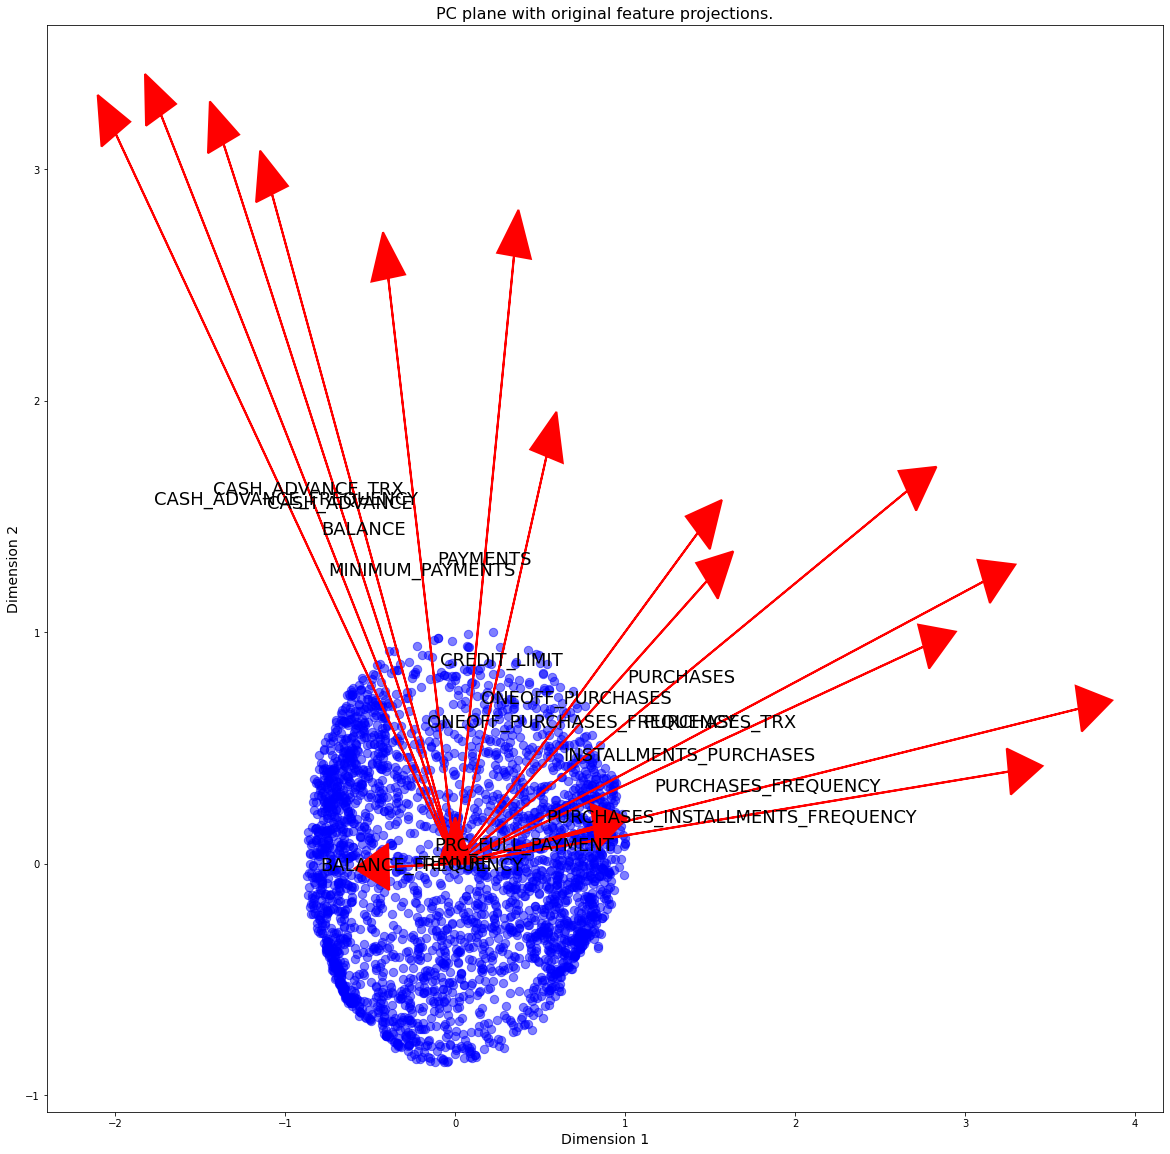

In [41]:
biplot(good_data, reduced_data, pca) #I suggest not to use biplot because if there were fewer features it could be more easy to interpret it

# <span style="color:Red"> <div align='center'> GMM 

When the number of clusters is not known a priori, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we quantify the "goodness" of a clustering by calculating each data point's silhouette coefficient. The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the mean silhouette coefficient provides for a simple scoring method of a given clustering.

We implement the following:

1.Fit a clustering algorithm to the reduced_data and assign it to clusterer.

2.Predict the cluster for each data point in reduced_data using clusterer.predict and assign them to preds.

3.Find the cluster centers using the algorithm's respective attribute and assign them to centers.

?Predict the cluster for each sample data point in pca_samples and assign them sample_preds.

4.Import sklearn.metrics.silhouette_score and calculate the silhouette score of reduced_data against preds.

5.Assign the silhouette score to score and print the result.

In [42]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score

def produceGMM(k):
    global clusterer, preds, centers, sample_preds
    
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = GMM(n_components=k, random_state=0)
    clusterer.fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_ 
    
    # ? Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(reduced_data)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data,preds)
    return score

results = pd.DataFrame(columns=['Silhouette Score'])
results.columns.name = 'Number of Clusters'    
for k in range(2,19):
    score = produceGMM(k) 
    results = results.append(pd.DataFrame([score],columns=['Silhouette Score'],index=[k]))

display(results)

Number of Clusters,Silhouette Score
2,0.456420
3,0.447450
4,0.386695
5,0.365380
6,0.358683
7,0.351524
8,0.302394
9,0.247805
10,0.243611
11,0.260968


In [43]:
#Out of 18 clusters tried we found the best score for 2 clusters having score of 0.4564

Bayesian information criterion (BIC)

This criterion gives us an estimation on how much is good the GMM in terms of predicting the data we actually have. The lower is the BIC, the better is the model to actually predict the data we have. In order to avoid overfitting, this technique penalizes models with big number of clusters.

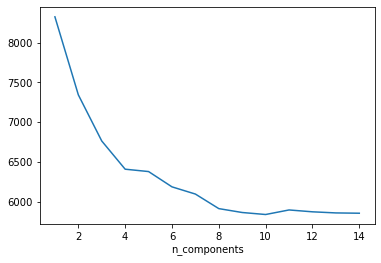

In [44]:
n_components = np.arange(1, 15)
models = [GMM(n).fit(reduced_data)
          for n in n_components]
plt.plot(n_components, [m.bic(reduced_data) for m in models], label='BIC')
plt.xlabel('n_components');

In [45]:
from sklearn.mixture import GaussianMixture 
lowest_bic = np.infty
bic = []
n_components_range = range(1, 15)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:

        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(reduced_data)
        bic.append(gmm.bic(reduced_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = [] 

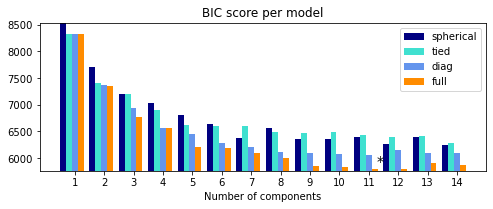

In [46]:
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

In [47]:
def cluster_results(reduced_data, preds, centers):

    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

	# Color map
    cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                   color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	

	# Set plot title
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

None

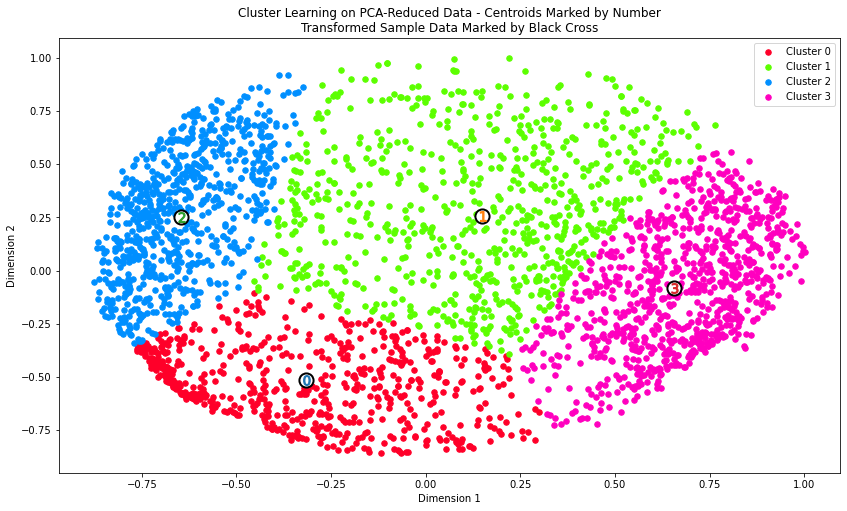

In [48]:
# GMM Visualization 
# Display the results of the clustering from implementation for 4 clusters
clusterer = GMM(n_components = 4)
clusterer.fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_ 


display(cluster_results(reduced_data, preds, centers))

Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the averages of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to the average customer of that segment. 

## With outliers

In [49]:
from sklearn.preprocessing import StandardScaler,normalize
# Standardize data
scaler = StandardScaler()
scaled = scaler.fit_transform(cc_mean) 
  
# Normalizing the Data 
normalized_df = normalize(scaled) 

# Converting the numpy array into a pandas DataFrame 
good_data = pd.DataFrame(data=normalized_df,columns=cc_mean.columns) 


In [50]:
'''from sklearn.preprocessing import StandardScaler
good_data = StandardScaler().fit_transform(cc_mean) 
good_data=pd.DataFrame(data=good_data,columns=cc_mean.columns)'''

'from sklearn.preprocessing import StandardScaler\ngood_data = StandardScaler().fit_transform(cc_mean) \ngood_data=pd.DataFrame(data=good_data,columns=cc_mean.columns)'

In [51]:
#good_data=cc_mean-cc_mean.mean()

In [52]:
import matplotlib.cm as cm

from sklearn.metrics import silhouette_score


def pca_results(good_data, pca):
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
    components.index = dimensions

	# PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

	# Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
            ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

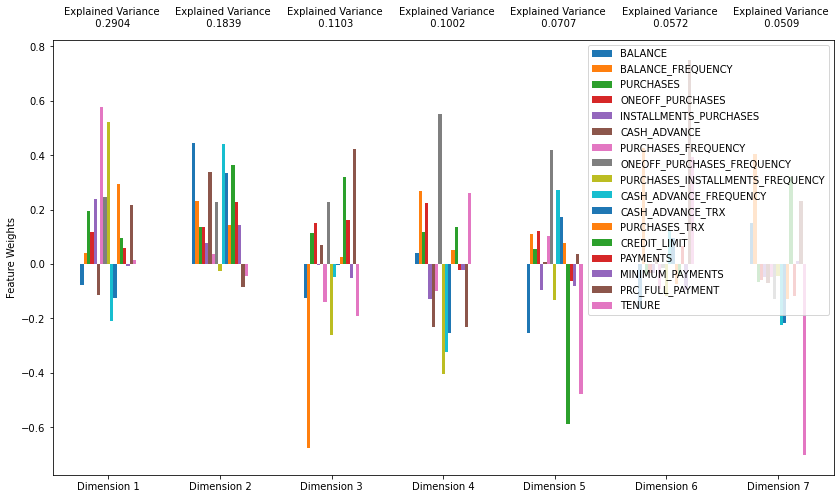

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=7).fit(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(good_data)

# Generate PCA results plot
pca_results = pca_results(good_data, pca)

Text(0.5, 0.98, 'explained variance by dim')

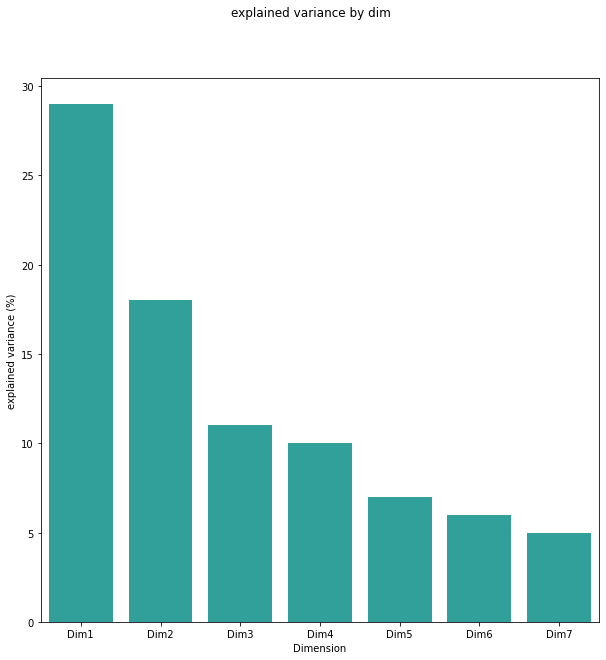

In [54]:
from sklearn import datasets
pca = PCA(n_components=7).fit(good_data)
pca.fit(good_data) 
# it is necessary to have normalized data before performing PCA. 
#The PCA calculates a new projection of data set. And the new axis are based on the standard deviation of variables.
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(7)], 
        "explained_variance" : pca.explained_variance_,
        "% explained_variance" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. explained" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    },
    columns = ["Dimension", "explained_variance", "% explained_variance", "% cum. var. explained"]
)
plt.figure(figsize=(10,10))

g_eig = sns.barplot(x = "Dimension", 
                y = "% explained_variance",
                palette = ["lightseagreen"],
                data = eig)
g_eig.set(ylabel = "explained variance (%)")
g_eig.figure.suptitle("explained variance by dim")



In [55]:
'''plt.figure(figsize=(8,5))
plt.plot(range(1,18),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.title("explained variable by components")
plt.xlabel("number of components")
plt.ylabel("cumulative variance")'''

'plt.figure(figsize=(8,5))\nplt.plot(range(1,18),pca.explained_variance_ratio_.cumsum(),marker=\'o\',linestyle=\'--\')\nplt.title("explained variable by components")\nplt.xlabel("number of components")\nplt.ylabel("cumulative variance")'

In [56]:
pca = PCA(n_components=2).fit(good_data)
reduced_data = pca.transform(good_data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
display(pd.DataFrame(np.round(reduced_data, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-0.4898,-0.6797
1,-0.5188,0.5450
2,0.3309,0.2690
3,-0.4824,-0.0921
4,-0.5633,-0.4819
...,...,...
8945,0.3287,-0.1985
8946,0.2599,-0.1677
8947,0.1888,-0.2485
8948,-0.3130,-0.1714


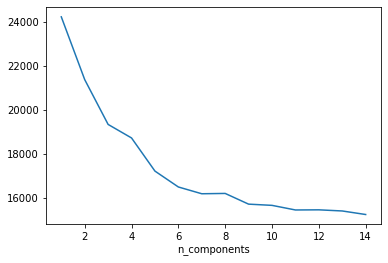

In [57]:
n_components = np.arange(1, 15)
models = [GMM(n).fit(reduced_data)
          for n in n_components]
plt.plot(n_components, [m.bic(reduced_data) for m in models], label='BIC')
plt.xlabel('n_components');

In [58]:
def cluster_results(reduced_data, preds, centers):

    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

	# Color map
    cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                   color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	

	# Set plot title
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

None

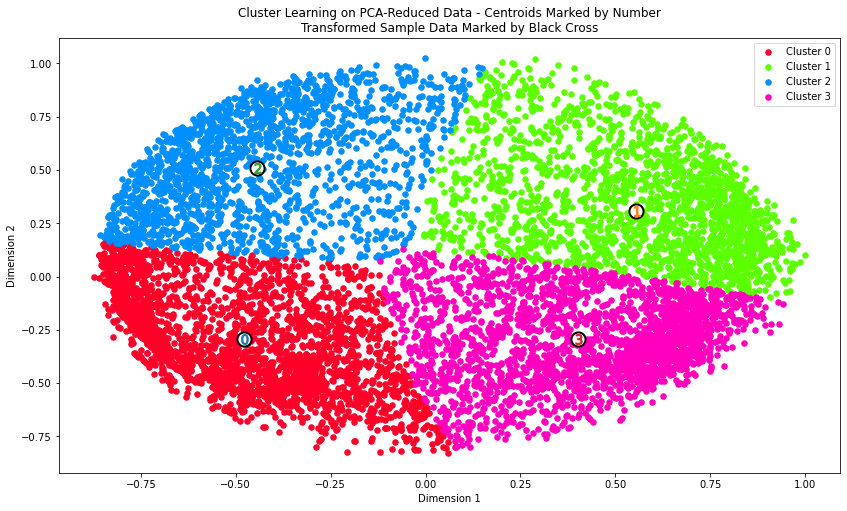

In [59]:
clusterer = GMM(n_components = 4)
clusterer.fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_ 


display(cluster_results(reduced_data, preds, centers))

## THE CLUSTERS

In [60]:
data = pd.concat([cc_mean, pd.DataFrame(preds, columns=['Cluster_gmm'], index=cc_mean.index)], axis=1)

In [61]:
pd.DataFrame(data['Cluster_gmm'].value_counts())

,Cluster_gmm
0,2793
3,2441
1,1980
2,1736


In [62]:
data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster_gmm
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,2
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,1
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,0
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


In [63]:
data.groupby('Cluster_gmm').mean() 

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
Cluster_gmm,,,,,,,,,,,,,,,,,
0,786.732187,0.770981,192.106434,152.889552,39.393530,432.883479,0.129113,0.064753,0.060928,0.089976,1.564984,2.052632,2763.300316,753.071687,460.483912,0.053365,11.513784
1,2295.250524,0.980670,3119.804975,1952.680086,1167.463778,807.653095,0.915885,0.558983,0.691370,0.110749,2.646970,43.015657,7081.036272,3413.652896,1316.083806,0.208640,11.787374
2,3611.455098,0.956482,282.142379,219.511653,62.689291,3349.444240,0.166763,0.099244,0.072178,0.405744,10.863479,3.328917,6253.007611,2642.231980,1598.971652,0.031888,11.329493
3,405.827374,0.858682,727.208918,257.236850,470.554035,56.560660,0.788640,0.144231,0.654374,0.014167,0.248259,14.326096,3126.485771,844.883574,437.057052,0.310624,11.435887


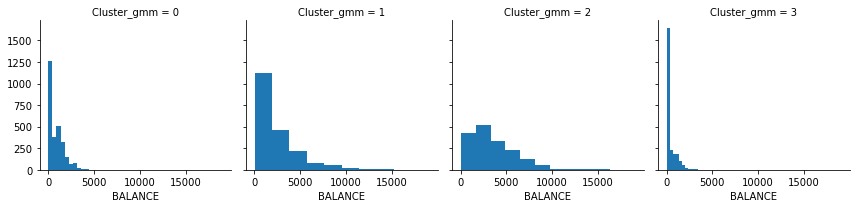

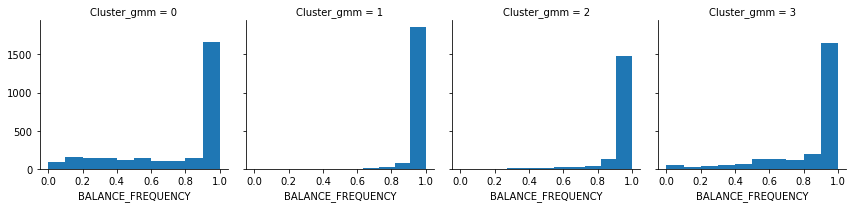

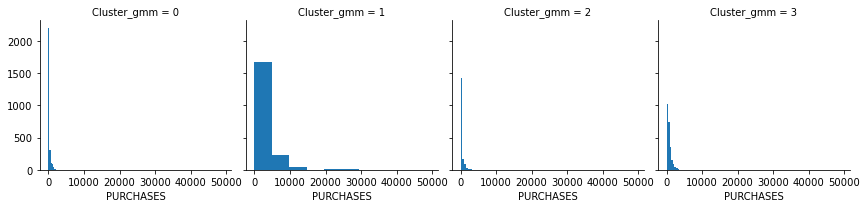

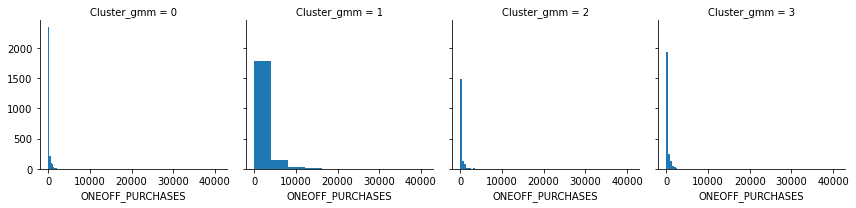

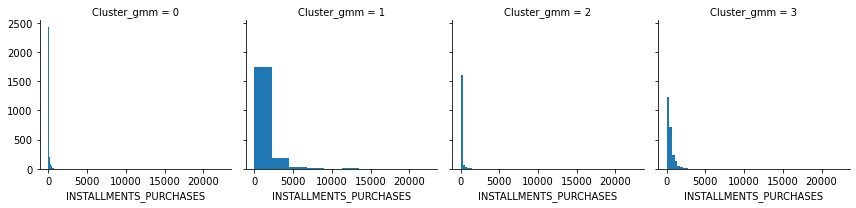

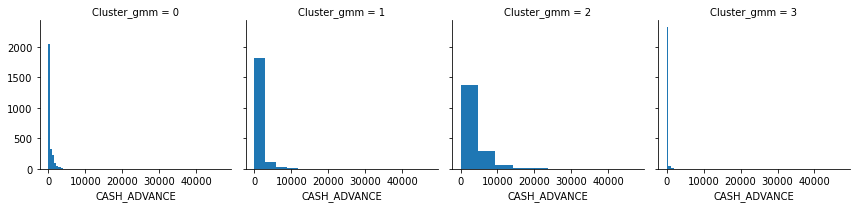

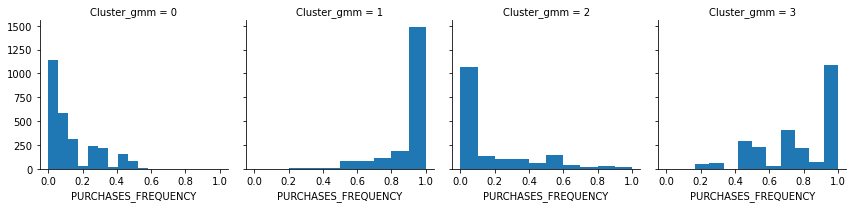

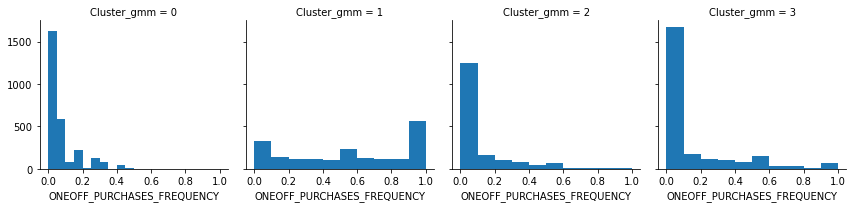

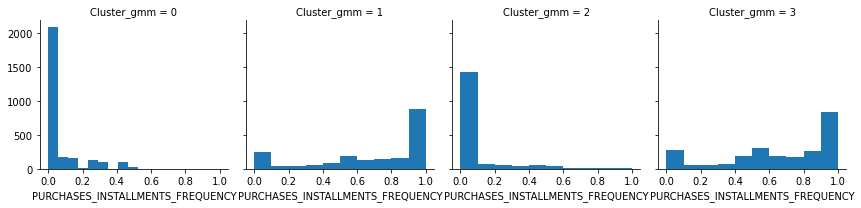

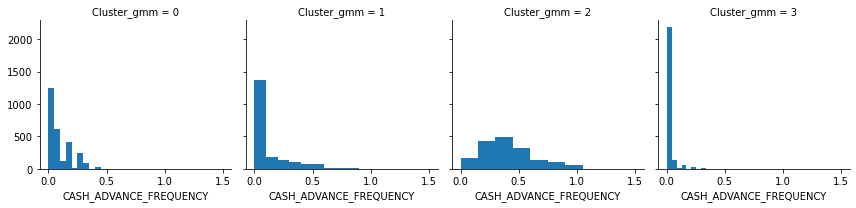

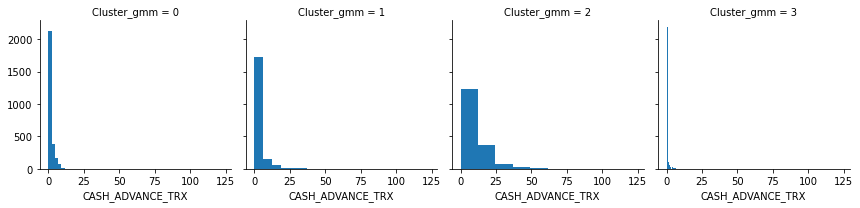

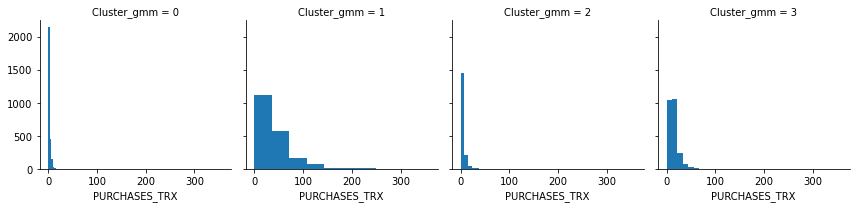

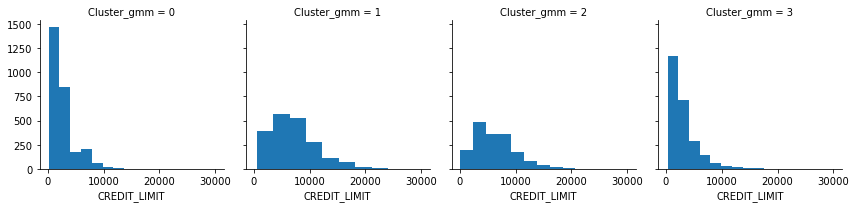

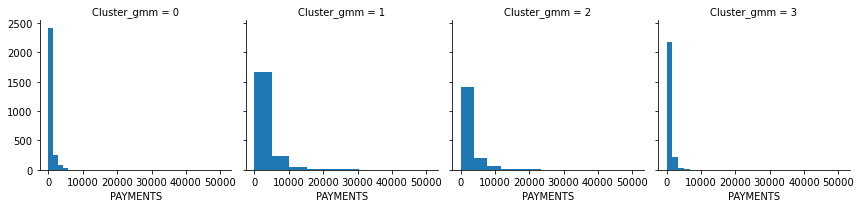

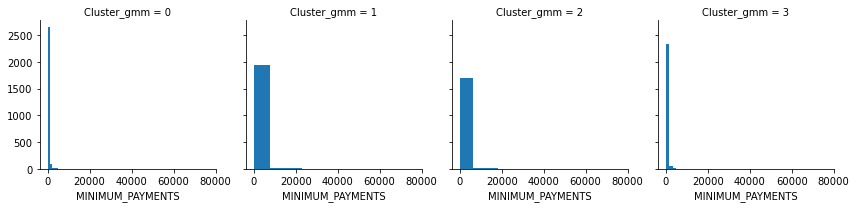

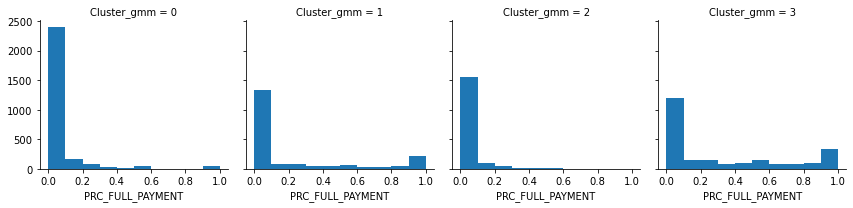

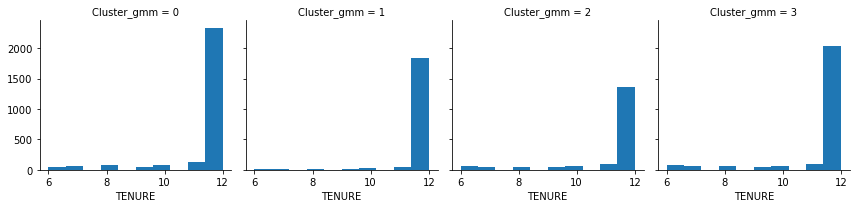

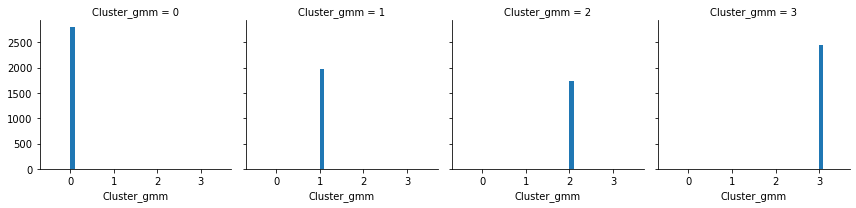

In [64]:
for c in data:
    grid= sns.FacetGrid(data, col='Cluster_gmm')
    grid.map(plt.hist, c)

# <span style="color:Red"> <div align='center'> K-means

The goal of this part is to compare the K-means method to the GMM one for the clusterisation task. In theory GMM should give better result because it is a more advanced method. But one question is: is it worth it to use more complexe method or do we get a result as good as the result from GMM with K-means ?

## Without outliers

In [104]:
reduced_data = pca.transform(good_data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [103]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def produceKmeans(k):
    global clusterer, preds, centers, sample_preds
    
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=k, random_state=0)
    clusterer.fit(reduced_data)
    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    
    # ? Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(reduced_data)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data,preds)
    return score

results = pd.DataFrame(columns=['Silhouette Score'])
results.columns.name = 'Number of Clusters'    
for k in range(2,19):
    score = produceKmeans(k) 
    results = results.append(pd.DataFrame([score],columns=['Silhouette Score'],index=[k]))

display(results)

Number of Clusters,Silhouette Score
2,0.447463
3,0.457998
4,0.426635
5,0.400634
6,0.388519
7,0.407214
8,0.402717
9,0.387197
10,0.374459
11,0.388106


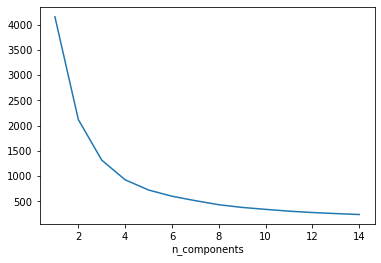

In [80]:
n_components = np.arange(1, 15)
models = [KMeans(n).fit(reduced_data)
          for n in n_components]
plt.plot(n_components, [-m.score(reduced_data) for m in models], label='Score')
plt.xlabel('n_components');

Score is sum of distances of samples to their closest cluster center. 

In [82]:
def cluster_results(reduced_data, preds, centers):

    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

	# Color map
    cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                   color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	

	# Set plot title
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

927.3338560937258


None

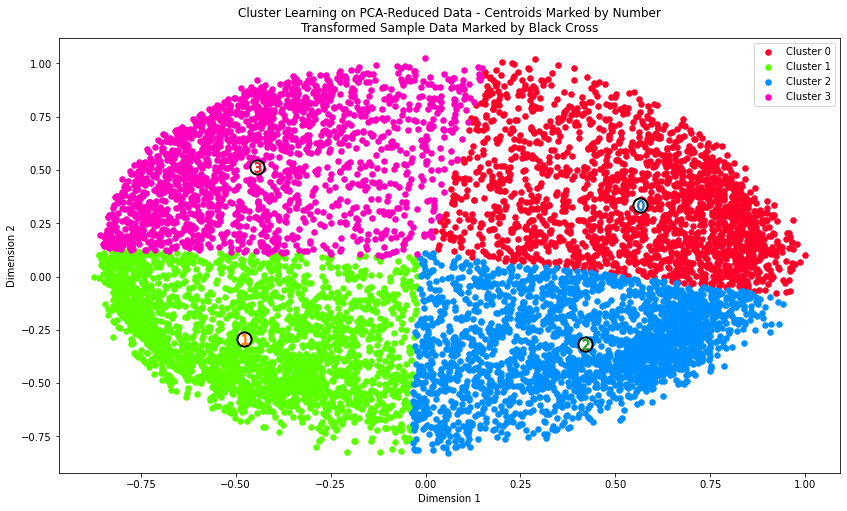

In [105]:
clusterer = KMeans(4)
clusterer.fit(reduced_data)
print(-clusterer.score(reduced_data))
preds = clusterer.predict(reduced_data)
centers = clusterer.cluster_centers_

display(cluster_results(reduced_data, preds, centers))

## With outliers

In [106]:
from sklearn.preprocessing import StandardScaler,normalize
# Standardize data
scaler = StandardScaler()
scaled = scaler.fit_transform(cc_mean) 
  
# Normalizing the Data 
normalized_df = normalize(scaled) 

# Converting the numpy array into a pandas DataFrame 
good_data = pd.DataFrame(data=normalized_df,columns=cc_mean.columns) 

In [107]:
pca = PCA(n_components=2).fit(good_data)
reduced_data = pca.transform(good_data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

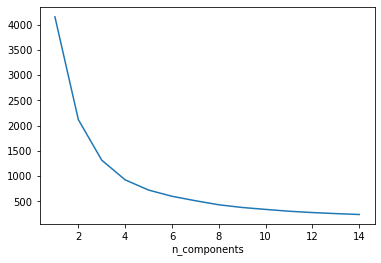

In [99]:
n_components = np.arange(1, 15)
models = [KMeans(n).fit(reduced_data)
          for n in n_components]
plt.plot(n_components, [-m.score(reduced_data) for m in models], label='Score')
plt.xlabel('n_components');

927.2643919073117


None

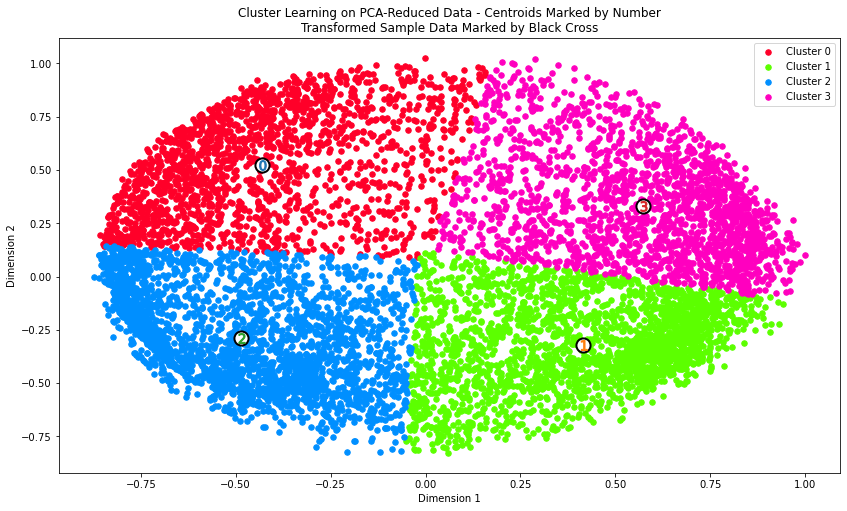

In [110]:
clusterer = KMeans(4)
clusterer.fit(reduced_data)
print(-clusterer.score(reduced_data))
preds = clusterer.predict(reduced_data)
centers = clusterer.cluster_centers_

display(cluster_results(reduced_data, preds, centers))

## THE CLUSTERS

In [111]:
data = pd.concat([cc_mean, pd.DataFrame(preds, columns=['Cluster_Kmeans'], index=cc_mean.index)], axis=1)

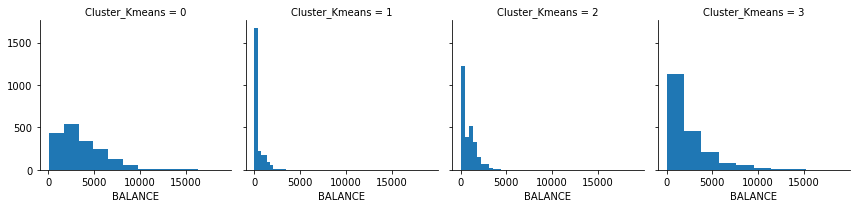

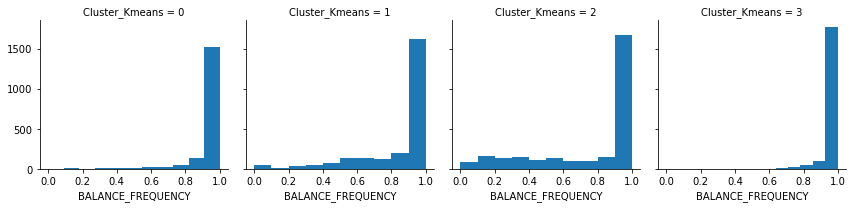

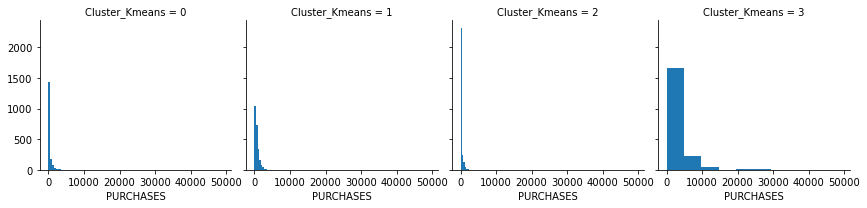

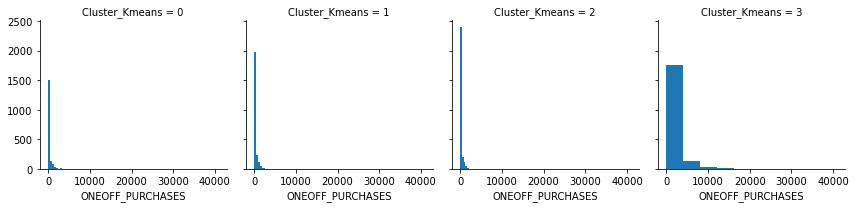

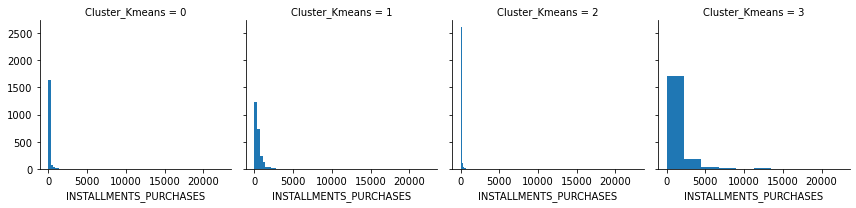

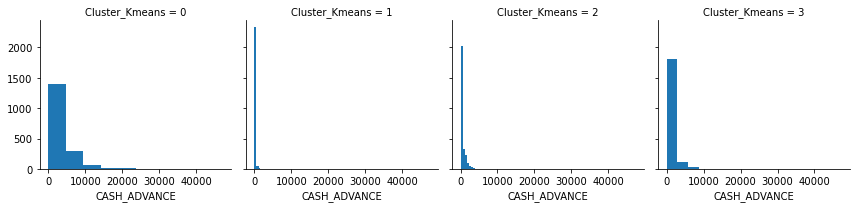

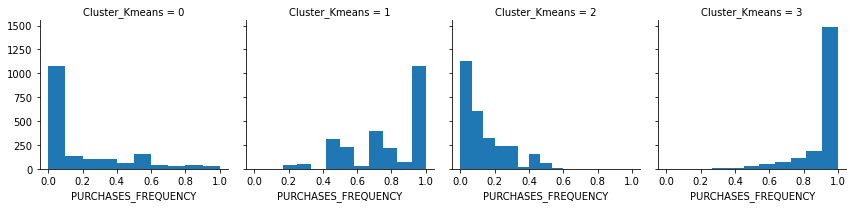

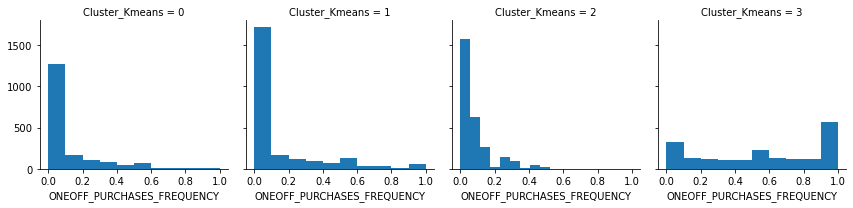

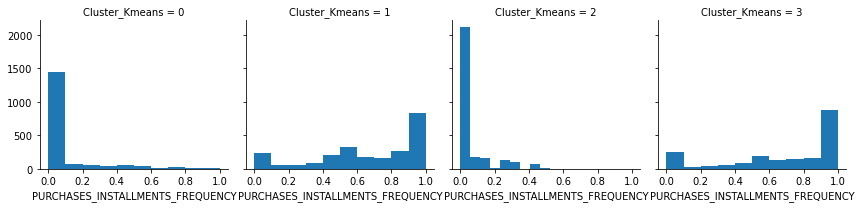

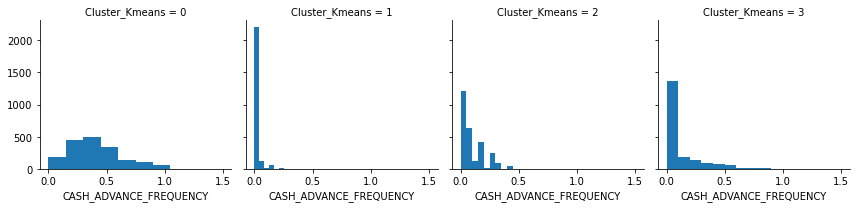

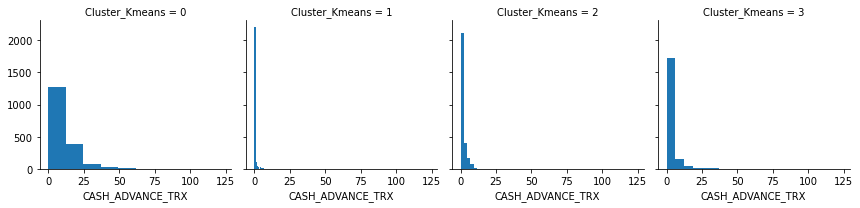

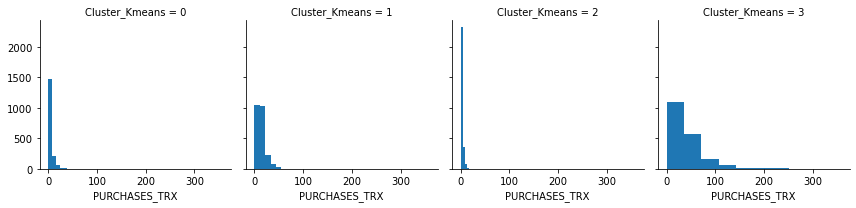

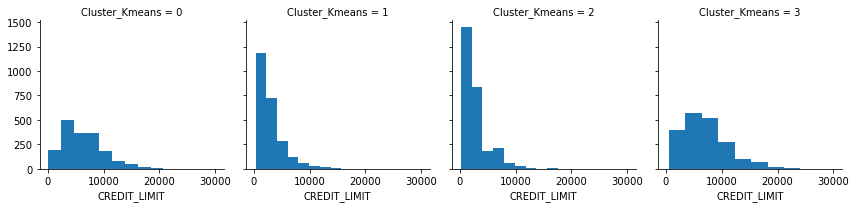

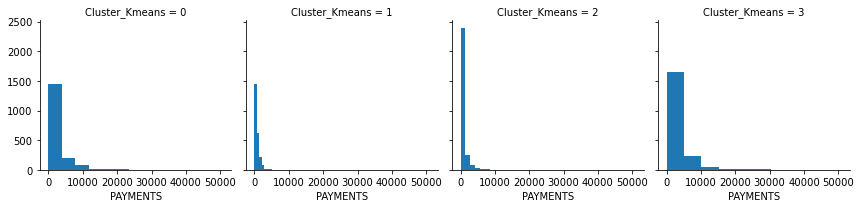

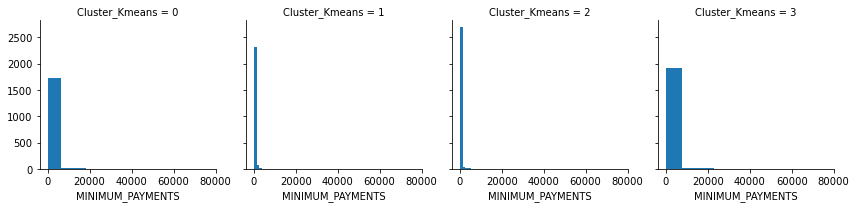

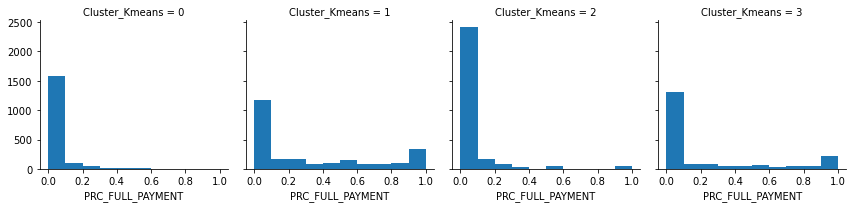

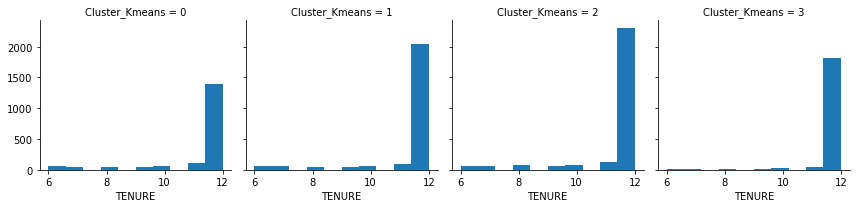

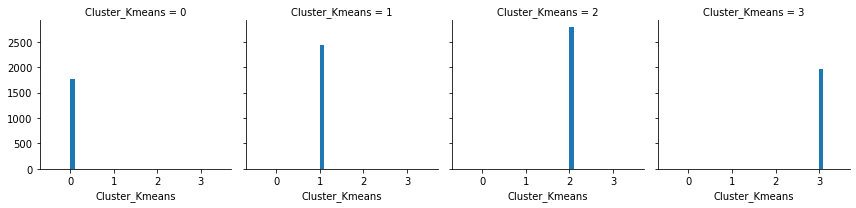

In [113]:
for c in data:
    grid= sns.FacetGrid(data, col='Cluster_Kmeans')
    grid.map(plt.hist, c)